<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 588 entries, 1970-01-01 to 2018-01-12
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   TRFVOLUSM227NFWA  588 non-null    int64
dtypes: int64(1)
memory usage: 9.2 KB


<Axes: xlabel='DATE'>

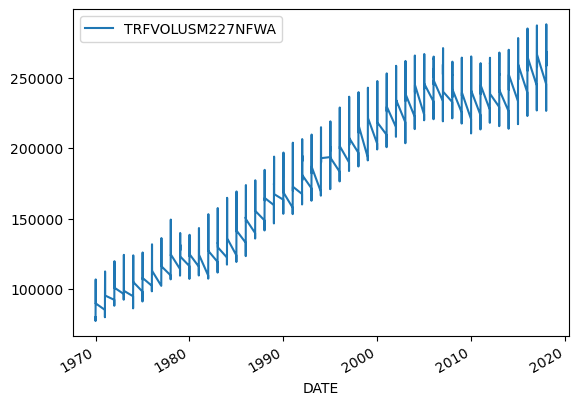

In [1]:
import pandas as pd
df = pd.read_csv('Miles_Traveled.csv',index_col='DATE',parse_dates=True)
df.info()
df.plot()

<Axes: xlabel='DATE'>

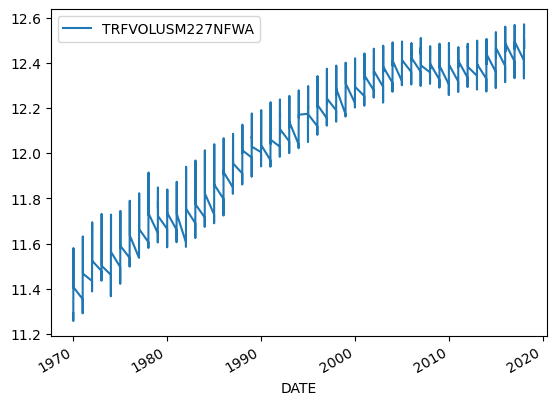

In [2]:
import numpy as np
df1 = np.log(df)
df1.plot()

In [3]:
msk = (df1.index < df1.index[-30])
df1_train = df1[msk].copy()
df1_test = df1[~msk].copy()

# checking stationarity

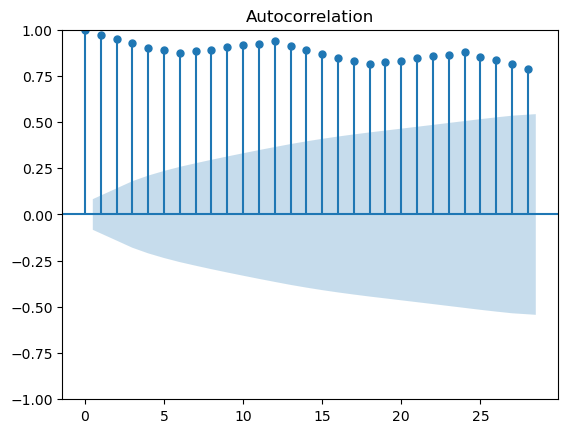

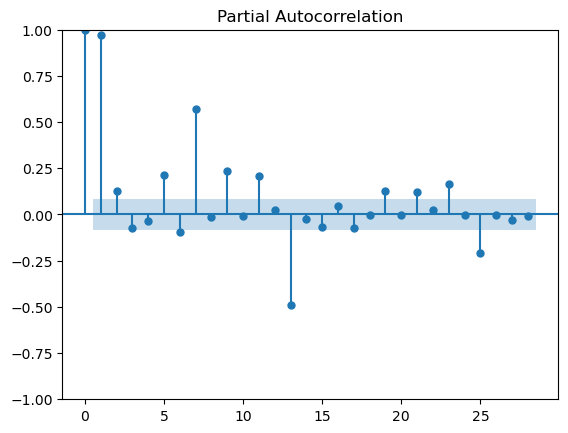

In [4]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
acf_original = plot_acf(df1_train)
pacf_original = plot_pacf(df1_train)

In [5]:
#checking stationarity with adf test
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df1_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.04521997640205613


# Transform to stationary:differencing

<Axes: xlabel='DATE'>

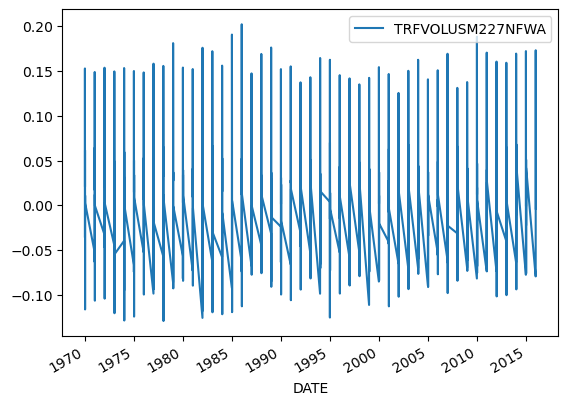

In [6]:
df1_train_diff = df1_train.diff().dropna()
df1_train_diff.plot()

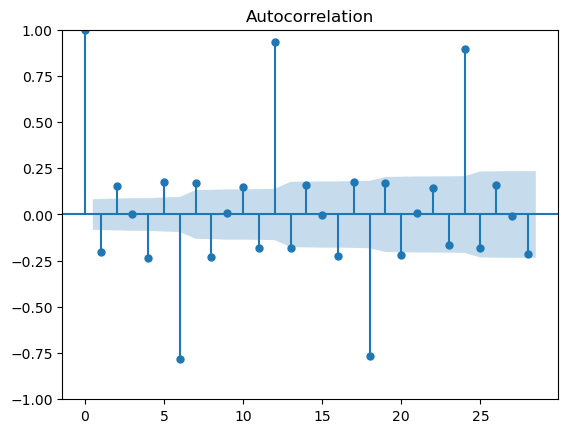

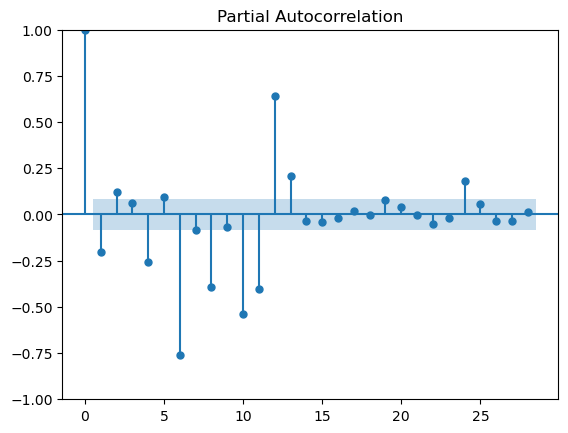

In [7]:
acf_diff = plot_acf(df1_train_diff)
pacf_diff = plot_pacf(df1_train_diff)

In [8]:
adf_test = adfuller(df1_train_diff)
print(f'p_values:{adf_test[1]}')

p_values:8.530581393355995e-05


# hence d=1
setting other parameters

In [9]:
!pip install pmdarima

In [10]:
from pmdarima import auto_arima
#ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
stepwise_fit = auto_arima(df1_train)
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  558
Model:               SARIMAX(4, 1, 4)   Log Likelihood                1054.445
Date:                Sun, 26 Jan 2025   AIC                          -2090.889
Time:                        02:46:50   BIC                          -2051.986
Sample:                             0   HQIC                         -2075.695
                                - 558                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0379      0.019     -1.986      0.047      -0.075      -0.000
ar.L2          0.9697      0.016     60.727      0.000       0.938       1.001
ar.L3          0.0311      0.020      1.554      0.120      -0.008       0.070
ar.L4         -0.9266      0.014    -65.813      0.000      -0.954      -0.899
ma.L1         -0.1244      0.028     -4.496      0.000      -0.179      -0.070
ma.L2         -1.3541      0.026    -51.989      0.000      -1.405      -1.303
ma.L3          0.0012      0.030      0.039      0.969      -0.058       0.060
ma.L4          0.8396      0.028     30.485      0.000       0.786       0.894
sigma2         0.0013   8.53e-05     15.297      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   2.44   Jarque-Bera (JB):                 2.49
Prob(Q):                              0.12   Prob(JB):                         0.29
Heteroskedasticity (H):               0.93   Skew:                            -0.15
Prob(H) (two-sided):                  0.63   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
import statsmodels.api as st
from statsmodels.tsa.arima.model import ARIMA
model = st.tsa.ARIMA(df1_train, order=(4,1,4))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       TRFVOLUSM227NFWA   No. Observations:                  558
Model:                 ARIMA(4, 1, 4)   Log Likelihood                1054.445
Date:                Sun, 26 Jan 2025   AIC                          -2090.889
Time:                        03:21:22   BIC                          -2051.986
Sample:                             0   HQIC                         -2075.695
                                - 558                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0379      0.019     -1.986      0.047      -0.075      -0.000
ar.L2          0.9697      0.016     60.727      0.000       0.938       1.001
ar.L3          0.0311      0.020      1.554      0.1

# Make predictions

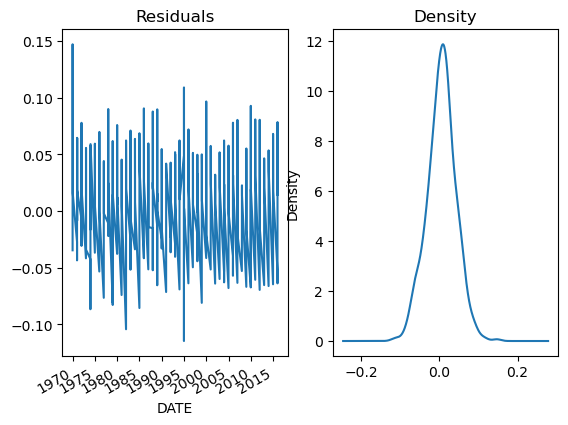

In [13]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig,ax = plt.subplots(1,2)
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

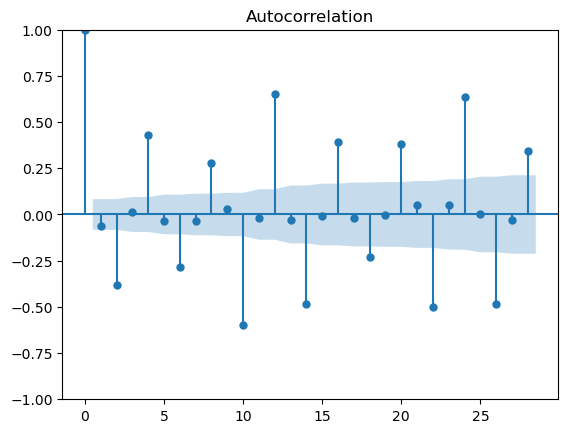

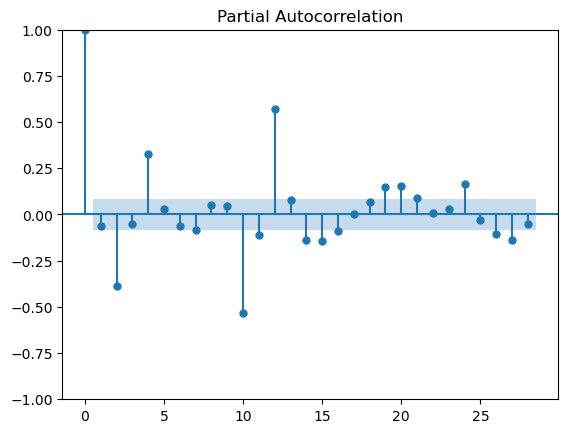

In [14]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

<Axes: xlabel='DATE'>

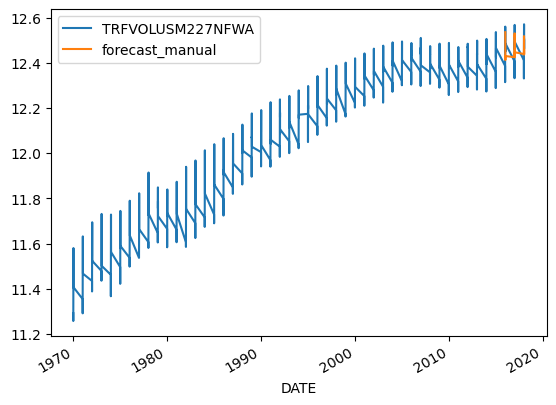

In [15]:
forecast_test = model_fit.forecast(len(df1_test))
df1['forecast_manual'] = [None]*len(df1_train)+list(forecast_test)
df1.plot()

# Make predictions on test data 

In [34]:
start = len(df1_train)
end = len(df1_train)+len(df1_test)-1

pred = model_fit.predict(start=start , end=end , typ='levels')
pred.index=df1.index[start:end+1]
print(pred)

DATE
2016-01-07    12.536082
2016-01-08    12.534525
2016-01-09    12.466814
2016-01-10    12.483242
2016-01-11    12.412888
2016-01-12    12.430817
2017-01-01    12.425168
2017-01-02    12.425356
2017-01-03    12.485619
2017-01-04    12.466729
2017-01-05    12.531122
2017-01-06    12.512068
2017-01-07    12.518804
2017-01-08    12.519580
2017-01-09    12.465823
2017-01-10    12.486477
2017-01-11    12.427349
2017-01-12    12.447224
2018-01-01    12.439589
2018-01-02    12.438172
2018-01-03    12.486228
2018-01-04    12.464381
2018-01-05    12.518839
2018-01-06    12.498399
2018-01-07    12.506773
2018-01-08    12.508574
2018-01-09    12.465530
2018-01-10    12.488107
2018-01-11    12.437808
2018-01-12    12.458597
Name: predicted_mean, dtype: float64


<Axes: xlabel='DATE'>

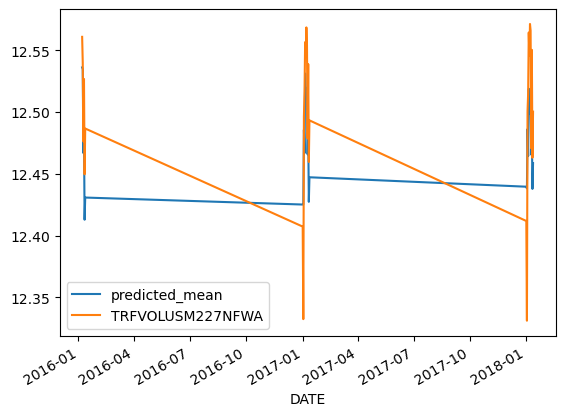

In [37]:
pred.plot(legend=True)
df1_test['TRFVOLUSM227NFWA'].plot(legend=True)

In [38]:
df1_test['TRFVOLUSM227NFWA'].mean()

12.49922129941178

In [40]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,df1_test['TRFVOLUSM227NFWA']))
print(rmse)

0.04584934053391206


In [41]:
model2 = ARIMA(df1['TRFVOLUSM227NFWA'],order=(4,1,4))
model2=model2.fit()
df1.tail

<bound method NDFrame.tail of             TRFVOLUSM227NFWA  forecast_manual
DATE                                         
1970-01-01         11.291942              NaN
1970-01-02         11.257285              NaN
1970-01-03         11.410040              NaN
1970-01-04         11.407076              NaN
1970-01-05         11.492437              NaN
...                      ...              ...
2018-01-08         12.565871        12.508574
2018-01-09         12.470723        12.465530
2018-01-10         12.550279        12.488107
2018-01-11         12.462999        12.437808
2018-01-12         12.500282        12.458597

[588 rows x 2 columns]>

In [47]:
#for future dates

index_future_dates=pd.date_range(start='2018-01-12', end='2018-2-11', freq='D')
print(index_future_dates)
pred=model2.predict(start=len(df1),end=len(df1)+30,typ='levels').rename('ARIMA Predictions')
pred.index=index_future_dates
print(pred)

DatetimeIndex(['2018-01-12', '2018-01-13', '2018-01-14', '2018-01-15',
               '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19',
               '2018-01-20', '2018-01-21', '2018-01-22', '2018-01-23',
               '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-27',
               '2018-01-28', '2018-01-29', '2018-01-30', '2018-01-31',
               '2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04',
               '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08',
               '2018-02-09', '2018-02-10', '2018-02-11'],
              dtype='datetime64[ns]', freq='D')
2018-01-12    12.493111
2018-01-13    12.446246
2018-01-14    12.524389
2018-01-15    12.469694
2018-01-16    12.552619
2018-01-17    12.542720
2018-01-18    12.548225
2018-01-19    12.591978
2018-01-20    12.517484
2018-01-21    12.571976
2018-01-22    12.494059
2018-01-23    12.506582
2018-01-24    12.502368
2018-01-25    12.461416
2018-01-26    12.532413
2018-01-27    12.478326
2018-01-28   

<Axes: >

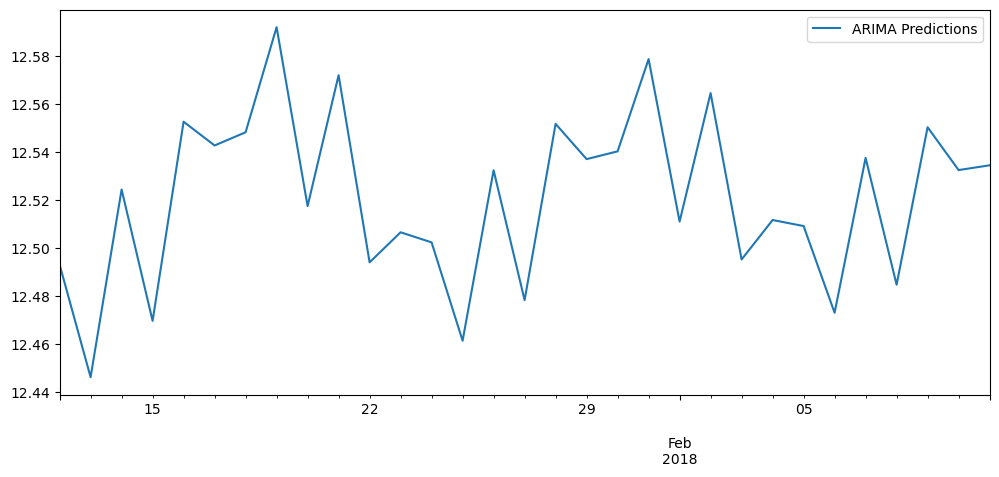

In [48]:
pred.plot(figsize=(12,5),legend=True)